# Machine Learning (CMP3751M/CMP9772M) - Assessment 02

Through the following notebook, you will be analysing a dataset and fitting a classification model to this dataset.

The assessment is structured as follows:
- [Dataset description](#Dataset-description)
- [Loading the dataset](#Loading-the-dataset)
- [Simple classification model](#Simple-classification-model)
    - [Creating a training and testing set](#Creating-a-training-and-testing-set)
    - [Training a classifier](#Training-a-classifier)
- [Improved evaluation strategy](#Improved-evaluation-strategy)
- [Different models and parameter search](#Different-models-and-parameter-search)
- [Ensembles](#Ensembles)
- [Final model evaluation](#Final-model-evaluation)
- [References](#References)

**Notes:**
- The (%) noted above are out of 100; this will be scaled down to **maximum of 60 marks** for the assessment **(or maximum of 50 marks for CMP9772M)** .
- Any discussion not supported by your implementation will not be awarded marks.
- **Do not modify** and code provided as a **TESTING CELL**.
- Make sure to **fix all the random seeds** in any parts of your solution, so it can be reproduced exactly.
- The notebook, as provided, runs without errors (without solving the assessment). Make sure that the solution, or the partial solution, you hand in, also **runs without errors** on the data provided. If you have a partial solution causing errors which you would like to show, please include it as a comment.
- Take care to include references to any external sources used. Check the [References](#References) section, the below cell, and the exambles through the assessment text for examples of how to do this.


In [34]:
# Remember to reference your sources! Check the bottom of the file, and examples used in the text of the assessment,
# for including references to papers and software in your textual answers

# Also add a reference in your solution cell before defining a class/function/method, eg.:

# This code is a modified and extended version of [2]
# OR
# This code is a modified and extended version of https://stackoverflow.com/q/522563/884412
##############
## THE CODE ##
##############

## Dataset description

The the assessment will be done on the dataset containing only numerical features describing the physical and chemical properties of the Li-ion battery, which can be classified on the basis of their crystal system [1]. (The dataset for this assessment has been adapted from the full dataset which can be found [here](https://www.kaggle.com/datasets/divyansh22/crystal-system-properties-for-liion-batteries), shared in the public domain by Divyansh Agrawal).

Each sample corresponds to the properties of a battery, and consists of following features:

| Feature Name      | Value | Description |
| :---------------- | :----- | ----------- |
| `Formation Energy`       | `float`: eV | Formation energy of the material. |
| `E Above Hull` | `float`: eV | Energy of decomposition of material into most stable ones. |
| `Band Gap` | `float`: eV | Band gap. |
| `Nsites` | `int`: count | Number of atoms in the unit cell of the crystal. |
| `Density` | `float`: gm/cc | The density of bulk crystalline materials. |
| `Volume` | `float` | The unit cell volume of the material. |

The goal for the assessment is to predict whether the crystal system of the battery is _monoclinic_, _orthorhombic_ or _triclinic_, which provides a classification for each sample:

| Class      | Value | Description |
| :---------------- | :----- | ----------- |
| `Crystal System`  | `string`: class designation | Class of the crystal system. |


## Loading the dataset

The dataset is given in _batteries.csv_ file provided on Blackboard. **Load the dataset into two [`numpy.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html)s.**: 
- The variable `X` should be a 2D [`numpy.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) containing all the samples and their features from the dataset, one sample per row. 
- The variable `y` should be a 1D [`numpy.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) containing the ground truth (class) as given in the `'Crystal System'` field of the _.csv_ file.
- _Note_: The class in the `'Crystal System'` column is given as a string. Make sure you encode the class as an integer number in your ground truth `y`.
- _Note_: You should make sure that your code for loading the dataset is guided by the information about the dataset, and the dataset description you provide as your answer.

**Describe the dataset**. Provide a basic description of the dataset. How many samples are there in the dataset? How many distinct classes? What types of features describe the samples in the dataset? Are there any missing values in the dataset? (Make sure these are properly handled). 
- _Note_: Make sure all your answers are supported by your implementation. Answers not supported by your implementation will not score any marks.

Provide your code to _load the dataset_ and the code that will allow you to _describe the dataset_ in the **SOLUTION CELL**. Provide your description of the dataset in the **ANSWER CELL**. A correct solution should result in no errors when running the **TESTING CELL** provided.

**SOLUTION CELL**

1. The dataset contains 339 samples and 7 columns of data.

2. The dataset has 3 distinct classes.

3. The features consist of Formation Energy, E Above Hull, Band Gap, Nsites, Density, Volume.

4. The features are of type:
Formation Energy    float64
E Above Hull        float64
Band Gap            float64
Nsites                int64
Density             float64
Volume              float64
Crystal System       object
dtype: object

5. Columns containing missing values (with count):
Formation Energy    1
E Above Hull        0
Band Gap            2
Nsites              0
Density             2
Volume              0
Crystal System      0
dtype: int64

6. Number of samples per class:
Crystal System
monoclinic      139
orthorhombic    128
triclinic        72
Name: count, dtype: int64

Outlier values for each feature:
Outliers from IQR method (Formation Energy):  []
Outliers from IQR method (E Above Hull):  [0.19]
Outliers from IQR method (Band Gap):  []
Outliers from IQR method (Nsites):  [92,

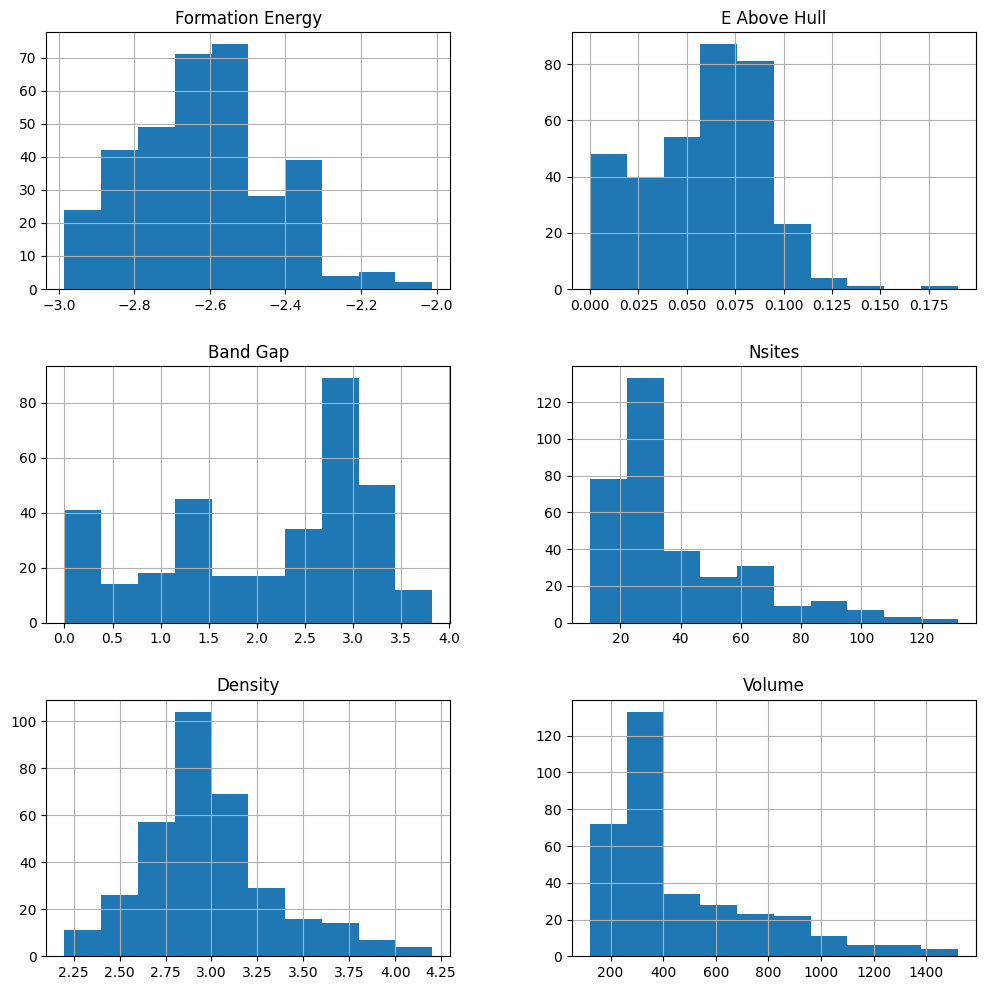

In [5]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the battery.csv data set into a pandas DataFrame
df = pd.read_csv('batteries.csv')

# Describe data set
print(f"1. The dataset contains {df.shape[0]} samples and {df.shape[1]} columns of data.\n")
print(f"2. The dataset has {len(df['Crystal System'].unique())} distinct classes.\n")
print(f"3. The features consist of {', '.join(df.columns[:-1])}.\n")
print(f"4. The features are of type:\n{df.dtypes}\n")
print(f"5. Columns containing missing values (with count):\n{df.isnull().sum()}\n")
print(f"6. Number of samples per class:\n{df['Crystal System'].value_counts()}\n")

# Define a mapping of categorical values to numeric values for the ground truths
class_mapping = {'monoclinic':0, 'orthorhombic':1, 'triclinic':2}

# Replace the categorical variables with the numeric ones
df['Crystal System'] = df['Crystal System'].replace(class_mapping)

# Load all samples and their features from the data frame into variable X
X = df.loc[:, df.columns!='Crystal System'].values

# Load the ground truth labels from the data frame into variable y
y = df["Crystal System"].values

# Handle missing values using simple imputer using the median strategy
# Create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy='median')

# Fit the imputer to the dataset
imputer.fit(X)

# Transform the dataset using the imputer
X = imputer.transform(X)

# Create a histogram for each feature (as there is not a vast amount of features) 
# to see if our data is normally distributed, if it is we can use z score to spot outliers,
# if not we can use IQR to find outliers
df.iloc[:,:-1].hist(figsize = (12, 12))


# Find outliers in data using IQR as we found upon inspection that the data is not normally distributed
outliers = []

# This code is a modified and extended version of https://www.freecodecamp.org/news/how-to-detect-outliers-in-machine-learning/
def detect_outliers_iqr(data):
    outliers.clear()
    
    # Sort the data in ascending order
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    # Calculate Inter quartile range
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)

    # Loop through the data and check if the value is an outlier
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
            
    return outliers

# Pass each df features columns 1 by 1 and see the potential outliers (expect the last column as it is the ground truth)
print("7. Outlier values for each feature:")
for column in df.iloc[:,:-1]:
    sample_outliers = detect_outliers_iqr(df[column])
    print(f"Outliers from IQR method ({column}): ", sample_outliers)

**TESTING CELL**

In [2]:
assert(len(X.shape) == 2)
assert(len(y.shape) == 1)
assert(X.shape[0] == y.shape[0])

**ANSWER CELL**

We can observe from our analysis that our dataset contains 339 samples with 7 columns of features (including our independent and dependent variables). In our dependent variable column (Crystal System), we can see there is 3 classes. There are 6 features that describe the samples in our dataset with different data types: Formation Energy (float64), E Above Hull (float64), Band Gap (float64), Nsites (int64), Density (float64), Volume(float64). Furthermore, it was found that the dataset is imbalanced for our dependent variable column (Crystal System). For class monoclinic there are 139 samples, orthorhombic there is 128 and triclinic only 72. This indicates that looking at the accuracy of models alone will not be a great indication of the models performance, "the reason is, a high accuracy (or low error) is achievable by a no skill model that only predicts the majority class" [12]. Prehaps we should look at other metrics such as precision, recall and f1-score.

Upon using the "isnull()" and "sum()" function we can get the count of missing values in each column, where we can see there are 3 columns with missing values: Formation Energy (1 missing value), Band Gap (2 missing values), Density (2 missing values). The missing data shows no pattern of missing values and from known context of our problem. "In other words, no systematic differences exist between participants with missing data and those with complete data" [9]; we can say the data is missing completely at random (MCAR). One method of handling MCAR values is to impute (fill in) the data or delete them, as there is only 5 missing values in total we can just take the mean and impute the data using sklearns "SimpleImputer". However, if there was a larger occurrence of missing values and a pattern of missing values could be identified, deleting or imputing the values could lead to bias.

Update: Upon inspection with histograms when spotting outliers (explained next) we found the feature data for the 3 columns wth missing values mentioned above are not normally distributed. Therefore, using the mean to impute the missing values would not be ideal as it would skew the data. Instead we updated our code to use median strategy to impute the missing values.

During pre-processing of data it is ideal to identify any outliers in our data and find a solution to handle them if necessary. To first identify outliers we need to ensure if our data is normally distributed or not, if the data shows normal distribution we can use Z-score to find outliers if not we can use the inter quartile range as it does not assume any specific distribution of the data. We have opted to use a histogram plot on each column of the dataset (not including the dependent variable column), to see if the data follows a normal distribution. We can see from the histogram plots that the data is not normally distributed and shows various distributions, therefore we will opt to use the inter quartile range to identify outliers. We defined a "detect_outliers_iqr" function that calculates the inter quartile range on a given list of data and finds the upper and lower bounds of the data and returns a list of outlier values. We passed the 6 feature values into the function to find out the outlier values for each feature. We can see from the output of the function that there are 3 features that contain outliers: E Above Hull, Nsites and, Volume. Although we have spotted outliers in our data, we will not remove them as we do not know enough about the dataset in depth to remove the values. "Outliers may be due to random variation or may indicate something scientifically interesting. In any event, we should not simply delete the outlying observation before a through investigation" [10]. As we do not have further given information about the dataset, we will keep the outliers as they could provide some valuable insights of the data or could in fact be correct recorded values.

## Simple classification model

To get the feel for the dataset, the first step will be to build train a simple classification model for this dataset. Do this in two steps detailed below:
1. Set aside some data for training and for testing.
2. Train a simple classifier on this data.

### Creating a training and testing set

**Set aside 20\% of the data for testing, and use the remaining 80\% to train your model.** Make sure to fix any random seeds if you use any functions or methods relying on those, so your experiments are _fully repeatable_. Initialise the following variables:
- `X_train` should contain the features corresponding to your training data.
- `y_train` should contain the ground truth of your training data.
- `X_test` should contain the features corresponding to your testing data.
- `y_train` should contain the ground truth associated to your testing data.

_Note:_ No additional marks will be rewarded for implementing an advanced data splitting strategy on this task. The purpose of this task is to start working with the dataset by applying a simple approach; you will have the chance to implement more complex evaluation pipelines in a later task.

Provide your implementation in the **SOLUTION CELL (a)** below. A correct solution should result in no errors when running the **TESTING CELL** provided.

### Training a classifier

**Train a simple classifier,** (of your choosing) **with fixed parameters** on the dataset, and **calculate accuracy on the test set**.
- Define a function `model_accuracy(y_test, y_pred)` to compare the ground truth given in `y_test` to predictions given in `y_pred` and calculate accuracy.
- **Store the model** in the variable named `model`. For the model, you may chose any classifier with which you are familiar (e.g. K Nearest Neighbours), or implement your own classifier. Make sure you **train your model** using the _training data_ only (`X_train`, `y_train`).
- Use the model to **predict the classes of the data** in the testing set (`X_test`), and calculate the accuracy by comparing the predictions with the ground truth for the testing set (`y_test`). **Store the predictions** in a variable called `y_test`.

_Note:_ Do not implement an advanced strategy to chose the parameters of your classifier here, as that will be a topic of a latter question.

_Note:_ If you implement your own classifier, make sure you implement it as a _class_ following the _sklearn_ standard for classifiers (i.e. make sure it implements the `fit(X, y)` method to train the model, and `predict(X)` method to use the trained model to predict the classes of provided samples.


**Discuss the advantages and shortcomings** of the evaluation strategy implemented through this task. Discuss both the data split used for evaluation and the choice of metric. Taking into account the information you know about the dataset, what kind of accuracy scores can you expect on this dataset from a good and bad performing model? Based on the information you have so far, comment on the performance of the model you have trained on the provided dataset.

Provide your implementation in the **SOLUTION CELL (b)** below. The **TESTING CELL** below should run without errors and will print the prediction of your model for the first sample in the test set, and the accuracy as calculated by your `model_accuracy` function. Provide your discussion in the **ANSWER CELL** below.

**SOLUTION CELL (a)**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data set into a training set and a test set 80 % / 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the data set as we have a several features with different data scales
scaler = StandardScaler()

# Fit the scaler to the training set and transform the training set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**TESTING CELL**

In [4]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
assert(X_train.shape[1] == X_test.shape[1])

**SOLUTION CELL (b)**

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def model_accuracy(y_test, y_pred):
    # Check that the input lists are of the same length
    assert(len(y_test) == len(y_pred))
    
    # Calculate the accuracy of the model
    accuracy = np.sum(y_test == y_pred) / len(y_test)
    
    return accuracy

# Create a basic KNN classifier
model = KNeighborsClassifier()
    
# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_predictions = model.predict(X_test)


**TESTING CELL**

In [6]:
print(model.predict(X_test[0].reshape(1,-1)))
print(model_accuracy(y_test, y_predictions))

[0]
0.5147058823529411


**ANSWER CELL**

After splitting our data using 80%/20% split we have chosen to standardize the data, we standardize data "when features of the input data set have large differences between their ranges, or simply when they are measured in different units (e.g., pounds, meters, miles, etc.)" [13]. We have chosen to use the StandardScaler function from sklearn to standardize our data. We have chosen to standardize the data after splitting the data into training and testing sets to prevent data leakage. "Data leakage is when information from outside the training dataset is used to create the model; this additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed" [14]. However another method similar to standardization is normalization where we rescale a dataset so that each value falls between 0 and 1. We have chosen to use standardization over normalization as we have some potential outliers in our data and normalization is more sensitive to outliers then standardization.

The evaluation method performed was accuracy. "It is a common metric used to measure the overall correctness of model’s predictions; it quantifies the ratio of correctly predicted instances to the total number of instances in the dataset" [15]. The accuracy evaluation strategy implemented through this task has some advantages and shortcomings. One advantage is that it provides a simple and straightforward way to evaluate the performance of a classifier on both the train and test data. However, there are also some shortcomings to this evaluation strategy.One shortcoming is for example, if the classes are imbalanced, accuracy may be misleading, as a classifier that always predicts the majority class will have a high accuracy but may not be useful in practice. Moreover, the choice of metric may not always be appropriate for the problem at hand. For example, in some cases, precision or recall may be more appropriate metrics to use.

An 80% / 20% training/test data split is common in machine learning tasks. However, one significant drawback is that the performance of the models can be highly dependent on the specific split of the data. For instance datasets with some infrequent classes or outliers then fitting the model to the data may produce unwanted results. A better evaluation strategy is k-fold cross validation.
"This is a widely used technique in machine learning and statistical modeling to assess the performance and generalization of a model. It helps in estimating how well a model will perform
on unseen data, which is crucial for avoiding either over fitting or under fitting" [15].

We can also utilize the use of leave-one-out cross validation (LOOCV). In leave-one-out cross validation, instead of using k folds, the data is used to train the model one time for each item in the set, using all other items as a training set and only one item as the testing set. This will give a model performance metric which is more robust to outliers in the data. However due to our model having a fair few samples (339 samples) this may not be the best approach to take, as LOOCV can be computationally expensive and time consuming.

Trying to construct a good / bad accuracy score we can get from the model depends on several factors such as the complexity of the problem, the quality of the data, and the choice of classification algorithm. Based on the structure of the dataset, the dataset having 6 features (independent variables), 3 possible classes (dependent variables) and 339 samples, we can expect a good performing model to achieve an accuracy score of around above 50%, while a bad performing model would achieve an accuracy score of around 50% or lower (essentially being 50% or lower is saying the model is worse then simply just guessing). Based on the information we have so far, the model we have trained on the provided dataset achieved an accuracy score of 51%. A accuracy score greater then 50%, is better then then just guessing, however is 51% is only 1% higher and has room for improvement. This suggests that the model may not be complex enough to capture the underlying patterns in the data. It is possible that a more complex model or a different classification algorithm may perform better on this dataset. However, it is also important to keep in mind that this is just a preliminary evaluation, and further optimization such as hyperparameter tuning may be possible.

## Improved evaluation strategy

After discussing the shortcomings of the simple evaluation strategy used in the previous task, you now have a chance to **propose a better evaluation strategy.** Make sure your chosen strategy **uses all the samples in the dataset** to report the result.
- Implement a function `evaluate_model(model, X, y)` to implement your proposed evaluation strategy. The function should evaluate the model given in `model` on the dataset given by `X` with ground truth given by `y`. Note that the function should be passed the _whole of the dataset_ (see **TESTING CELL** below) and should take care of any data splitting internally.
- If desired, you may add additional arguments to this function, as long as they have default values and the function runs correctly when called using those default values.
- The function should return no values, but instead print the results of the evaluation in a human-readable format.
- Include at least one summative metric (providing a single number, e.g. accuracy) and per-class metric (e.g. precision). You are encouraged to select more than one metric of each type.

This function will be used to provide a better evaluation of the simple model with fixed parameters used in the previous task.

**Discuss your chosen evaluation strategy**, including both the data split and the evaluation metrics. Which data splitting strategy did you chose and why? Which metrics did you chose, and why? Briefly explain the chosen data splitting strategy. What additional information can your additional metrics provide beyond accuracy?

Provide your implementation of this function in the **SOLUTION CELL**. You may also include any additional evaluation calls you want to include in this code cell. The **TESTING CELL** will perform a basic evaluation of your `model` using the `evaluate_model` function implemented for this task. Provide your discussion in the **ANSWER CELL** below.

**SOLUTION CELL**

In [7]:
from sklearn.model_selection import  cross_validate, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

"""
Function to evaluate a model
@param model: machine learning model to evaluate
@param X: data set to evaluate the model on (features)
@param y: ground truth labels for the data set (labels)
@param model_name: name of the model to evaluate (default: 'model')
@return: Printed results of the evaluation strategy
"""
def evaluate_model(model, X, y, model_name='model'):
    print(f'Evaluating {model_name}...')
    
    # This code is a modified and extended version of [5]
    # Define the pipeline with a scaler and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # This code is a modified and extended version of [3] [4]
    # Define the cross-validation method
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # Define the evaluation metrics
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro','matthews_corrcoef']

    # Perform cross-validation and get per-class metrics
    results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=True)

    # Print the per-class metrics for each fold
    for i, estimator in enumerate(results['estimator']):
        y_pred = estimator.predict(X)
        report = classification_report(y, y_pred, output_dict=True)
        print(f'Fold {i+1}:')
        print(f"Class monoclinic: precision={report[str(class_mapping['monoclinic'])]['precision']:.3f}, recall={report[str(class_mapping['monoclinic'])]['recall']:.3f}, f1-score={report[str(class_mapping['monoclinic'])]['f1-score']:.3f}")
        print(f"Class orthorhombic: precision={report[str(class_mapping['orthorhombic'])]['precision']:.3f}, recall={report[str(class_mapping['orthorhombic'])]['recall']:.3f}, f1-score={report[str(class_mapping['orthorhombic'])]['f1-score']:.3f}")
        print(f"Class triclinic: precision={report[str(class_mapping['triclinic'])]['precision']:.3f}, recall={report[str(class_mapping['triclinic'])]['recall']:.3f}, f1-score={report[str(class_mapping['triclinic'])]['f1-score']:.3f}\n")
    
    # Print the overall accuracy and MCC
    print(f'\nAccuracy: {results["test_accuracy"].mean():.3f}')
    print(f'MCC: {results["test_matthews_corrcoef"].mean():.3f}')

    

**TESTING CELL**

In [8]:
evaluate_model(model, X, y, "Simple KNN")

Evaluating Simple KNN...
Fold 1:
Class monoclinic: precision=0.617, recall=0.719, f1-score=0.664
Class orthorhombic: precision=0.701, recall=0.789, f1-score=0.743
Class triclinic: precision=0.727, recall=0.333, f1-score=0.457

Fold 2:
Class monoclinic: precision=0.648, recall=0.741, f1-score=0.691
Class orthorhombic: precision=0.715, recall=0.805, f1-score=0.757
Class triclinic: precision=0.806, recall=0.403, f1-score=0.537

Fold 3:
Class monoclinic: precision=0.624, recall=0.669, f1-score=0.646
Class orthorhombic: precision=0.682, recall=0.805, f1-score=0.738
Class triclinic: precision=0.667, recall=0.361, f1-score=0.468

Fold 4:
Class monoclinic: precision=0.631, recall=0.712, f1-score=0.669
Class orthorhombic: precision=0.691, recall=0.805, f1-score=0.744
Class triclinic: precision=0.758, recall=0.347, f1-score=0.476

Fold 5:
Class monoclinic: precision=0.636, recall=0.741, f1-score=0.684
Class orthorhombic: precision=0.694, recall=0.781, f1-score=0.735
Class triclinic: precision=0.

**ANSWER CELL**

The data splitting strategy we have opted for is stratified k-fold cross validation. This is due to fact we identified that the class samples in our dataset are imbalanced. "Stratified folds are especially useful when your variable of interest is imbalanced. That is, when the class frequencies differ to a great extent. Stratification ensures that the class frequencies in all folds are similar to the frequencies in the original data" [16]. This is a better approach then a simple 80/20 train test split as it gives a more robust estimate of the models performance as we can average results across multiple folds, preserves class proportions and better utilization of the data as we are both training and evaluating with samples in the dataset. We used 10 folds for our stratified k-fold cross validation, as this is a common number of folds used in machine learning tasks. This process helps to ensure that the model’s performance is assessed on all data points, providing a more robust estimate of its ability to generalize to unseen data. In our evaluate_model function we have also defined a pipeline object consisting of our standard scaler and the model, this is so we can standardize the data and train the model in one step.

For our evaluation metrics we used 2 summative metrics and 3 per-class metrics. The summative metrics we have chosen are accuracy and Mathews Coefficient (MCC). Accuracy was chosen as it is a common metric used to measure the overall correctness of model’s predictions as mentioned in the previous task. MCC was chosen as "it takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes" [11], which is true for our scenario. Also MCC will give a different perspective of the models performance compared to accuracy. "The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction" [17]. The per-class metrics we have chosen are precision, recall and f1-score. Precision was chosen as it is a metric that measures the proportion of positive identifications that were actually correct. Recall was chosen as it is a metric that measures the proportion of actual positives that were identified correctly. F1-score was chosen as it is a metric that is a weighted average of the precision and recall. These metrics will give us a better understanding of the models performance on the per class level at each fold of the cross validation, rather then just looking at the overall model performance with summative metrics like accuracy and MCC.

## Different models and parameter search

Now that you have a [better evaluation strategy](#Improved-evaluation-strategy) implemented, it is time to try out different models, and try out different parameter combinations for these models.

**Fit at least three different (types of) machine learning models** to the provided dataset. (_Note:_ Make sure at least 2 out of your 3 chosen types have different model parameters which can be adjusted). **Try different parameters for all of your models** (which have parameters). Use a single summative metric of your choice to choose between the different types of models, and the models with different parameters. Finally, **choose thee different models, one of each type** and assign them to variables `model_1`, `model_2` and `model_3`.

**Discuss your choice of models, and your procedure to adjust the model parameters**. Discuss how you reached the decision about the best model amongst the models of the same type (which metric was selected, and why). Also discuss any shortcomings of your approach and how (and if) you could improve on this. After evaluating these models on the dataset, **discuss and compare their performance on the provided data.**

Implement your solution in the **SOLUTION CELL**. The **TESTING CELL** will evaluate the three best models selected by you, using your evaluation strategy. Discuss your choices in the **ANSWER CELL**.

**SOLUTION CELL**

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
# We will create and hyper parameter tune 3 models, a KNN, SVM and a Decision Tree

# Check the workshops for each model and see what hyper parameters we can tune

# Create SVM model
from sklearn.svm import SVC
model_1 = SVC(random_state=0)

# Create Decision Tree model
from sklearn.tree import DecisionTreeClassifier
model_2 = DecisionTreeClassifier(random_state=0)

# Create KNN model
from sklearn.neighbors import KNeighborsClassifier
model_3 = KNeighborsClassifier()

# Perform hyper parameter tuning on each model

# Create a dictionary of hyper parameters for each model
svm_parameters = {'kernel':['poly', 'rbf'], 'C':[0.1, 1, 10, 100], 'gamma':['scale', 'auto', 0.1, 1], 'degree':list(range(1, 10))}
dt_parameters = {'criterion':['gini', 'entropy'], 'splitter':['best', 'random'], 'max_depth':list(range(1,200))}

# For knn neighbor param, we make sure it is odd to prevent ties
knn_parameters = {'n_neighbors':[i for i in range(2, 31) if i % 2 != 0], 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'leaf_size':[i for i in range(1, 40)], 'p':[1, 2], 'metric':['minkowski', 'euclidean', 'manhattan']}

# Create a dictionary of the models
models = {'Decision_Tree':model_2, 'KNN':model_3, 'SVM':model_1}

# Create a dictionary of the parameters
parameters = {'SVM':svm_parameters, 'Decision_Tree':dt_parameters, 'KNN':knn_parameters}

# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=10)

# Loop through each model and perform hyper parameter tuning
for model_name, model in models.items():
    print(f"Performing hyper parameter tuning on {model_name}...")
    
    # Create a grid search object and fit it to the data to perform hyper parameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=parameters[model_name], scoring="accuracy", cv=skf, n_jobs=-1)
    
    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)
    
    # Get the optimal hyperparameters and corresponding accuracy score
    print(f"Best parameters: {grid_search.best_params_}, Best Score: {grid_search.best_score_}")
    
    # Fit the best parameters to the model
    model.set_params(**grid_search.best_params_)
    
# Display the parameters for each model
print(f"\nDecision Tree parameters: {model_2.get_params()}")
print(f"KNN parameters: {model_3.get_params()}")
print(f"SVM parameters: {model_1.get_params()}")


Performing hyper parameter tuning on Decision_Tree...
Best parameters: {'criterion': 'entropy', 'max_depth': 11, 'splitter': 'random'}, Best Score: 0.6052910052910053
Performing hyper parameter tuning on KNN...
Best parameters: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, Best Score: 0.5835978835978836
Performing hyper parameter tuning on SVM...
Best parameters: {'C': 100, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}, Best Score: 0.5980158730158729

Decision Tree parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'random'}
KNN parameters: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
SVM para

**TESTING CELL**

In [15]:
evaluate_model(model_1, X, y, "SVM")
print()
evaluate_model(model_2, X, y, "Decision Tree")
print()
evaluate_model(model_3, X, y, "KNN")

Evaluating SVM...
Fold 1:
Class monoclinic: precision=0.866, recall=0.835, f1-score=0.850
Class orthorhombic: precision=0.848, recall=0.914, f1-score=0.880
Class triclinic: precision=0.940, recall=0.875, f1-score=0.906

Fold 2:
Class monoclinic: precision=0.888, recall=0.799, f1-score=0.841
Class orthorhombic: precision=0.829, recall=0.906, f1-score=0.866
Class triclinic: precision=0.878, recall=0.903, f1-score=0.890

Fold 3:
Class monoclinic: precision=0.821, recall=0.856, f1-score=0.838
Class orthorhombic: precision=0.872, recall=0.852, f1-score=0.862
Class triclinic: precision=0.913, recall=0.875, f1-score=0.894

Fold 4:
Class monoclinic: precision=0.846, recall=0.827, f1-score=0.836
Class orthorhombic: precision=0.828, recall=0.867, f1-score=0.847
Class triclinic: precision=0.913, recall=0.875, f1-score=0.894

Fold 5:
Class monoclinic: precision=0.863, recall=0.813, f1-score=0.837
Class orthorhombic: precision=0.830, recall=0.914, f1-score=0.870
Class triclinic: precision=0.910, re

**ANSWER CELL**

Our choice of models was based on choosing 3 models that would allow hyper parameter tuning and met the needs our problem, the problem being a multi class classification problem (3 classes of crystal systems). We chose to use a decision tree classifier, a support vector machine classifier and a k nearest neighbors classifier. We chose to use a decision tree classifier as it is a simple model that is easy to interpret and understand, it is also a non parametric model which means it does not make any assumptions about the underlying distribution of the data. We chose to use a support vector machine classifier as it is a powerful model that can be used for both classification and regression problems, it is also a non parametric model. Finally we chose to use a k nearest neighbors classifier as it is a simple model that is easy to interpret and understand, it is also a non parametric model. All three models supported multi class classification problems and allowed for hyper parameter tuning. Additionally, we chose these 3 algorithms due to there unique characteristics, meaning they take different approaches and can provide vary results. This is ideal as it is better then comparing 3 models that take similar approaches and most likely will give similar results and this would not provide us with any meaningful insight of the strengths and weaknesses of different algorithmic approaches. Computation time for all 3 models was not a concern as the dataset is relatively small (339 samples). However, for reference the training complexity of SVM is O(n^2), showing a quadratic relationship with the number of samples, while the training complexity of KNN is O(n), showing a linear relationship with the number of samples [18]. The training complexity of decision trees is generally O(n*log(n)*d)
n = number of points in the Training set, d = dimentionality of the data [19]. Therefore, SVM is the most computationally expensive model out of the 3 models we have chosen.

The procedure we took to find the optimal parameters was by performing grid search using stratified k-fold cross validation. We chose to use stratified k-fold cross validation instead of k-fold cross validation due to the class imbalance in the dataset and the smaller dataset size. Stratified k-fold cross validation is a variation of k-fold cross validation, where the folds are selected so that the mean response value is approximately equal in all the folds. This is a better approach then a simple k-fold cross validation as it gives a more robust estimate of the models performance as we can average results across multiple folds, preserves class proportions and better utilization of the data as we are both training and evaluating with samples in the dataset. We used 10 folds for our stratified k-fold cross validation, as this is a common number of folds used in machine learning tasks. This process helps to ensure that the model’s performance is assessed on all data points, providing a more robust estimate of its ability to generalize to unseen data. We used accuracy as the metric for the grid search, as stratified cross validation helps balance out the dataset, and accuracy is a good metric for balanced datasets. Grid search requires you to pass in a parameter grid, which is a dictionary of parameters and the values you want to test for each parameter. In our example we defined 3 different dictionaries for each model and a set of different parameters that can be tuned for each model, which a range of values to test. After performing grid search on all 3 models, it returns back the optimal model parameters and the best accuracy score. We then used these optimal parameters to train the model and evaluate the model using our evaluate_model function.

After hyperparameter tuning , for our evaluation results we can see that SVM an accuracy of 57% and a MCC of 0.33, this is a slight improvement over the simple model we trained in the previous task. Decision tree gave a accuracy of 55% and MCC of 0.31, this is a worse accuracy then our SVM model and a lower MCC value, however still indicates a moderate positive relationship between the observed and predicted classifications. Finally, our KNN model gave a accuracy of 55% and MCC of 0.30, which is the worst performing of the 3 models, but just barely based on the MCC value.

In the future to improve on the above approach we could try pass in a greater range of values for each parameter in the parameter grid for each model. This would allow us to compare and evaluate a larger range of parameter values and potentially find better performing models. The reason this was avoided for our current approach was due to the computational time, seeing espicially as models such a SVM has a O(n^2) training complexity, the higher range of parameters we want to test the time taken would quadratically increase. Also, utilising random search in the future could be another interesting approach as it would eliminate the computation time issue. "The chances of finding the optimal parameter are comparatively higher in random search because of the random search pattern where the model might end up being trained on the optimised parameters without any aliasing" [20]. Finally another improvement we could make is to use a different evaluation metric such as precision, recall and f1-score. This would give us a better understanding of the models performance on the per class level at each fold of the cross validation, rather then just looking at the overall model performance with summative metrics like accuracy and MCC.

## Ensembles

Sometimes, combining different weak classification models can improve the overall performance of the model. **Implement bagging** for each of your three classification models (`model_1`, `model_2`, `model_3`) [from the previous task](#Different-models-and-parameter-search). Store your models performing bagging over your based models calculated in the previous task in variables called `bagged_1`, `bagged_2` and `bagged_3`. Provide your implementation, running any additional evaluation needed, in the **SOLUTION CELL**

The **TESTING CELL** will evaluate your 3 bagged models using your own evaluation procedure. It will also make a voting ensemble consisting of your three base models (`model_1`, `model_2`, `model_3`) and another one made of your bagged models (`bagged_1`, `bagged_2` and `bagged_3`), and evaluate these three voting ensembles.

**Discuss** the effect on bagging on your base models. Discuss how you chose the bagging parameters, and justify your choice. Discuss the effect using the voting ensemble had on your model performance. Compare the effect of a voting ensemble on the ensemble models to the effect on the base models. Provide your discussion in the **ANSWER CELL** below.

**SOLUTION CELL**

In [11]:
from sklearn.ensemble import BaggingClassifier
import numpy as np

# Create a bagging classifier for each model                                                                                                                                                                                                                                            
bagged_1 = BaggingClassifier(model_1, random_state=0)
bagged_2 = BaggingClassifier(model_2, random_state=0)
bagged_3 = BaggingClassifier(model_3, random_state=0)

# Define the parameter search grid for Hyper parameter tuning the bagged models using grid search
param_grid = {'n_estimators':np.arange(1, 150, 10), 'max_samples':np.arange(0.1, 1.1, 0.1), 'max_features':np.arange(1, 7, 1)}

# Make a dictionary of the bagged models
bagged_models = {'SVM':bagged_1, 'Decision_Tree':bagged_2, 'KNN':bagged_3}

# Loop through each bagged model and perform hyper parameter tuning
for model_name, model in bagged_models.items():
    print(f"Performing bagging hyper parameter tuning on {model_name}...")
    
    # Create a grid search object and fit it to the data to perform hyper parameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="accuracy", cv=skf, n_jobs=-1)
    
    # Fit the grid search object to the data
    grid_search.fit(X_train, y_train)
    
    # Get the optimal hyperparameters and corresponding accuracy score
    print(f"Best parameters: {grid_search.best_params_}, Best Score: {grid_search.best_score_}")
    
    # Fit the best parameters to the model
    model.set_params(**grid_search.best_params_)


Performing bagging hyper parameter tuning on SVM...
Best parameters: {'max_features': 6, 'max_samples': 0.9, 'n_estimators': 141}, Best Score: 0.624074074074074
Performing bagging hyper parameter tuning on Decision_Tree...
Best parameters: {'max_features': 3, 'max_samples': 1.0, 'n_estimators': 61}, Best Score: 0.6645502645502644
Performing bagging hyper parameter tuning on KNN...
Best parameters: {'max_features': 6, 'max_samples': 1.0, 'n_estimators': 61}, Best Score: 0.5984126984126984


**TESTING CELL**

In [46]:
from sklearn.ensemble import VotingClassifier

eclf  = VotingClassifier(estimators=[('CLF1', model_1), ('CLF2', model_2), ('CLF3', model_3)], voting='hard')
ebclf  = VotingClassifier(estimators=[('BCLF1', bagged_1), ('BCLF2', bagged_2), ('BCLF3', bagged_3)], voting='hard')

evaluate_model(bagged_1, X, y, "Bagged SVM")
print()
evaluate_model(bagged_2, X, y, "Bagged Decision Tree")
print()
evaluate_model(bagged_3, X, y, "Bagged KNN")
print()
evaluate_model(eclf, X, y, "Ensemble Base Models")
print()
evaluate_model(ebclf, X, y, "Ensemble Bagged Models")

Evaluating Bagged SVM...
Fold 1:
Class monoclinic: precision=0.869, recall=0.856, f1-score=0.862
Class orthorhombic: precision=0.854, recall=0.914, f1-score=0.883
Class triclinic: precision=0.969, recall=0.875, f1-score=0.920

Fold 2:
Class monoclinic: precision=0.873, recall=0.842, f1-score=0.857
Class orthorhombic: precision=0.858, recall=0.898, f1-score=0.878
Class triclinic: precision=0.887, recall=0.875, f1-score=0.881

Fold 3:
Class monoclinic: precision=0.857, recall=0.863, f1-score=0.860
Class orthorhombic: precision=0.864, recall=0.891, f1-score=0.877
Class triclinic: precision=0.940, recall=0.875, f1-score=0.906

Fold 4:
Class monoclinic: precision=0.854, recall=0.842, f1-score=0.848
Class orthorhombic: precision=0.836, recall=0.875, f1-score=0.855
Class triclinic: precision=0.941, recall=0.889, f1-score=0.914

Fold 5:
Class monoclinic: precision=0.869, recall=0.856, f1-score=0.862
Class orthorhombic: precision=0.860, recall=0.914, f1-score=0.886
Class triclinic: precision=0.

**ANSWER CELL**

We have chosen the bagging parameters by researching the most influential parameters, and passing in a suitable range of values to test on through the use of grid search. Through research 3 different bagging parameters should to have the most effect on the bagging performance. The first parameter we chose to tune was the number of decision trees. "Typically, the number of trees is increased until the model performance stabilizes. Intuition might suggest that more trees will lead to over fitting, although this is not the case. Bagging and related ensemble of decision trees algorithms (like random forest) appear to be somewhat immune to over fitting the training dataset given the stochastic nature of the learning algorithm" [6]. The number of trees parameter is the "n_estimators", and we have given the grid search a range of values from 1 to 150 with increments of 10. Then next parameter was want to tune for all 3 models using grid search was the number of samples used to fit each decision tree. "The default is to create a bootstrap sample that has the same number of examples as the original dataset. Using a smaller dataset can increase the variance of the resulting decision trees and could result in better overall performance" [6]. We can use the "max_samples", for this parameter we can pass in a ratio of the original dataset from 10% to 100% in increments of 10%. The final parameter we chose to tune was the max features, this features controls the number of features that are used for the training of the base models. "It is important as by setting "max_features" to a value less than the total number of features, you introduce more randomness into the model. This can help to reduce over fitting by ensuring that each individual model is slightly different" [7]. We used grid search to find the optimal parameter values for each of the 3 bagged models, along with setting the scoring method as accuracy, and using 10 fold stratified cross validation.

We can observe from the above results that bagging has improved the performance for both SVM and decision tree model, shown from our evaluate_model method. SVM (non-bagged) had an accuracy of 57%, however after bagging it showed an accuracy of 58%, for decision tree (non-bagged) it showed an accuracy of 55% and after bagged 63%. On the other hand, for KNN (non-bagged) an accuracy of 55% was shown, but after bagging only had a accuracy of 54%, showing a a slight lose in accuracy. This is expected as "it is pointless to bag nearest-neighbor classifiers because their output changes very little if the training data is perturbed by sampling" [8]. This is also reflects in our ensemble models, as the voting ensemble with the bagged models (58% accuracy) performed worse then the non bagged models (60% accuracy).

The ensemble method used for all 6 models (3 base models and the 3 bagged models) was hard voting. In this method we are counting the votes of each classifier equally. For our non-bagged models ensemble we got back an accuracy of 60% and MCC of 0.39, this is a slight improvement of the accuracy all the base models got individually from the previous task. For our bagged models ensemble we received an accuracy of 58% and MCC of 0.34, this is a slight decrease in accuracy compared to the non-bagged models ensemble. This is could be due to the voting method we chose, as if 2 of the worse performing models (knn and svm) outvote the wrong prediction of the best performing model (decision tree) the ensemble will predict the wrong class. Instead of hard voting we could have used soft voting, where the predicted class labels of each model are weighted by the confidence of the model, meaning the better individually performing model (decision tree) would have more confidence and skew the vote towards the correct prediction. This could have improved the accuracy of the bagged models ensemble. In addition, in the future we could attempt to apply a different ensemble method such as boosting. "In boosting, a random sample of data is selected, fitted with a model and then trained sequentially—that is, each model tries to compensate for the weaknesses of its predecessor" [21]. Comparing both voting and boosting, boosting is more likely to improve the performance of the model, as it is a sequential process that attempts to correct the mistakes of the previous models. This is different to voting, as voting is a parallel process that combines the predictions of multiple models to make a final prediction. However, to reach a definite conclusion on which ensemble method is better, we would need to test and compare both methods on our dataset.

## Final model evaluation

Based on all the experiments performed for this assessment, **choose a single best model, evaluate it** with [your evaluation procedure](#Improved-evaluation-strategy) and also **display the confusion matrix**. **Discuss the performance achieved by this model**.

**You should attempt this cell even if you have not successfully trained all the models required in this assessment, and comment on the best model which _you_ have obtanied.**

Implement your solution in the **SOLUTION CELL** below. Add your discussion to the **ANSWER CELL** below.

**SOLUTION CELL**

Evaluating model...


C:\Users\Mathews\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 1:
Class monoclinic: precision=0.965, recall=0.978, f1-score=0.971
Class orthorhombic: precision=0.977, recall=0.977, f1-score=0.977
Class triclinic: precision=0.986, recall=0.958, f1-score=0.972

Fold 2:
Class monoclinic: precision=0.956, recall=0.935, f1-score=0.945
Class orthorhombic: precision=0.932, recall=0.961, f1-score=0.946
Class triclinic: precision=0.958, recall=0.944, f1-score=0.951

Fold 3:
Class monoclinic: precision=0.957, recall=0.971, f1-score=0.964
Class orthorhombic: precision=0.962, recall=0.977, f1-score=0.969
Class triclinic: precision=1.000, recall=0.944, f1-score=0.971

Fold 4:
Class monoclinic: precision=0.924, recall=0.957, f1-score=0.940
Class orthorhombic: precision=0.975, recall=0.930, f1-score=0.952
Class triclinic: precision=0.945, recall=0.958, f1-score=0.952

Fold 5:
Class monoclinic: precision=0.957, recall=0.964, f1-score=0.961
Class orthorhombic: precision=0.961, recall=0.969, f1-score=0.965
Class triclinic: precision=0.971, recall=0.944, f1-sco

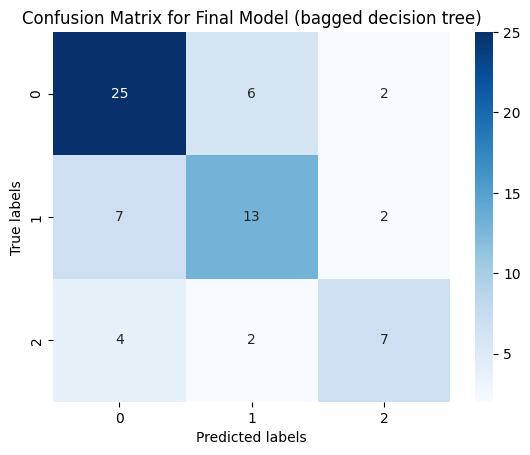

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Choose the final model
# Our bagged decision tree model performed the best from the previous evaluations
final_model = bagged_2

# Fit the final model to the training data
final_model.fit(X_train, y_train)

# Evaluate the final model
evaluate_model(final_model, X, y)

# Produce a confusion matrix for the final model
conf_matrix = confusion_matrix(y_test, final_model.predict(X_test))

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.title('Confusion Matrix for Final Model (bagged decision tree)')

# Display the plot
plt.show()


**ANSWER CELL**

It was decided to use the final model as the bagged version of the decision tree classifier, as this was the model that gave the best accuracy after evaluation in the previous task.
It showed a significant increase in overall accuracy and MCC from its base model after hyperparameter tuning giving an overall Accuracy: 55% and MCC: 0.31, to after applying bagging giving us an overall  Accuracy: 63% and MCC: 0.42.  

We achieve an accuracy score of 63% which is much improved over the simple class classifier at 51%. The MCC metric confirm that we have now constructed a much better classifier, with scores of around 0.42. Matthews coefficient of 0.42 overall suggests a moderate positive relationship between the predicted and actual values. This means that the final model is doing a better job than a random prediction, but there’s still room for improvement. This could be due to the fact that the dataset is quite small, and the classes are imbalanced. Further testing on a larger dataset with more samples would be needed to confirm this and also trialing out different classification algorithms such a random forest classifier, as it is an ensemble method and can help reduce over fitting, and also can help with the class imbalance in the dataset.

 The confusion matrix however still shows that the minority class is under performing with respect to the other two:
- Class 0 is performing the best, however is much more often misclassified as class 1 than as class 2.
- Class 1 is performing second best, and is more likely to be misclassified as class 0 then class 2.
- Class 2 is performing the worst, as it is the minority class. It is quite often confused with class 0.

## References

[1] Divyansh Agrawal: Crystal System Properties for Li-ion batteries (dataset) https://www.kaggle.com/datasets/divyansh22/crystal-system-properties-for-liion-batteries/discussion (accessed 28/08/2023)

[2] Mateen Ulhaq, Mike Hordecki (code) https://stackoverflow.com/a/522578/884412 (accessed 24/08/2023)

[3] https://www.askpython.com/python/examples/k-fold-cross-validation

[4] https://stackoverflow.com/questions/46598301/how-to-compute-precision-recall-and-f1-score-of-an-imbalanced-dataset-for-k-fold

[5] https://stackoverflow.com/questions/58939568/standardize-data-with-k-fold-cross-validation

[6] https://machinelearningmastery.com/bagging-ensemble-with-python/

[7] https://stackoverflow.com/questions/23939750/understanding-max-features-parameter-in-randomforestregressor

[8] Witten, Ian H., et al. Data Mining: Practical machine learning tools and techniques. Morgan Kaufmann, 2016.

[9] https://www.ncbi.nlm.nih.gov/books/NBK493614/

[10] https://www.researchgate.net/post/When_is_it_justifiable_to_exclude_outlier_data_points_from_statistical_analyses

[11] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

[12] https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

[13] https://builtin.com/data-science/when-and-why-standardize-your-data

[14] https://machinelearningmastery.com/data-leakage-machine-learning/

[15] Frantzidis, Christos, Lecture 2: Model selection & evaluation, lecture slides, Machine Learning, CMP3751, University of Lincoln, delivered 3rd October 2023

[16] https://statisticsglobe.com/stratified-k-fold-cross-validation-r

[17] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

[18] https://stats.stackexchange.com/questions/96995/machine-learning-classifiers-big-o-or-complexity

[19] https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770

[20] https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318

[21] https://www.ibm.com/topics/boosting


# RE ORDER THE REFERENCES AND IN THE ANSWER CELLS BASED ON TASK ORDER